# Test backward grad

In [45]:
import torch

x = torch.randn(5, 4)
w1 = torch.randn(3, 4, requires_grad=True)
b1 = torch.randn(3, 1, requires_grad=True)
w2 = torch.randn(2, 3, requires_grad=True)
b2 = torch.randn(2, 1, requires_grad=True)

z1 = w1.mm(x.transpose(0,1)) + b1
a1 = torch.nn.functional.relu(z1)
z2 = w2.mm(z1) + b2
a2 = torch.nn.functional.relu(z2)
out = torch.sigmoid(a2)

print(out)

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]], grad_fn=<SigmoidBackward>)


In [46]:
out.backward(torch.randn(*list(out.size())))

In [3]:
print(w1.grad)
print(b1.grad)
print("------")
print(w2.grad)
print(b2.grad)

tensor([[-0.3740, -0.3311, -0.1820,  0.5891],
        [ 0.0549, -0.0344,  0.0158,  0.0205],
        [-0.1224, -0.5186, -0.1133,  0.7211]])
tensor([[-0.3913],
        [ 0.0431],
        [-0.1989]])
------
tensor([[-1.0895, -1.1245,  0.1947],
        [-0.1390, -0.8206,  0.7192]])
tensor([[0.3708],
        [0.4800]])


In [4]:
w1[2]

tensor([ 1.0565, -0.7693, -0.4482, -0.2268], grad_fn=<SelectBackward>)

In [5]:
w = torch.randn(3, 3, requires_grad=True)
x = torch.randn(2, 3, requires_grad=False)
y = w.mm(x.transpose(0, 1))
# while y.data.norm() < 1000:
#     y = y * 2 + 4


print(w)
print(y)

tensor([[ 0.2579, -0.3149, -0.2374],
        [ 0.0986,  3.0364, -1.0167],
        [-0.8371, -1.0230, -2.1830]], requires_grad=True)
tensor([[ 0.2908, -0.0725],
        [-2.8346, -2.3837],
        [-2.4688,  0.4630]], grad_fn=<MmBackward>)


# A basic forward prop

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Loading data/Training

In [7]:
# Import Data Module
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


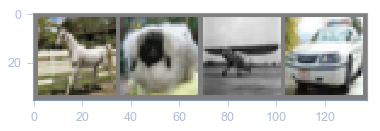

horse   dog plane   car


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    """
    Defines the convolutional network
    """
    
    def __init__(self):
        """
        Initializes/Define the parameters to be tunes during training
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, [5, 5])
        self.pool2 = nn.MaxPool2d(3, 3)
        self.conv3 = nn.Conv2d(6, 12, [4, 4])
        self.pool4 = nn.MaxPool2d(2, 2)
        self.fc5 = nn.Linear(12 * 3 * 3, 58)
        self.fc6 = nn.Linear(58, 20)
        self.fc7 = nn.Linear(20, 10)
        
    def forward(self, x):
#         print("x", x.shape)
        x = F.relu(self.conv1(x))
#         print("conv1", x.shape)
        x = self.pool2(x)
#         print("pool2", x.shape)
        x = F.relu(self.conv3(x))
#         print("conv3", x.shape)
        x = self.pool4(x)
#         print("pool4", x.shape)
        x = x.view(-1, 12 * 3 * 3)
#         print("reshape", x.shape)
        x = F.relu(self.fc5(x))
#         print("fc5", x.shape)
        x = F.relu(self.fc6(x))
#         print("fc6", x.shape)
        out = self.fc7(x)
#         print("fc7", out.shape)
        
        return out

    
net = ConvNet()
# Test with one sample
x1 = trainset[0][0]
net.forward(x1.unsqueeze(0))

tensor([[ 0.0098,  0.1662, -0.2596, -0.1287, -0.2286,  0.0513,  0.0979,  0.0896,
          0.1037,  0.0547]], grad_fn=<AddmmBackward>)

In [19]:
# Define Optimizer
import torch.optim as optim

# Define Loss
xentropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# Define Constant
EPOCHS = 5

data = iter(trainloader).next()


for epoch in range(EPOCHS):
    print("Epoch: %d" % (epoch+1))
    # Loss of each record point
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get inputs
        inputs, labels = data
        
        # Zero buffer
        net.zero_grad()
        
        # train
        outputs = net(inputs)
        loss = xentropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print every few iterations
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print("    Minibach: %d | loss: %.3f" % 
                  (i + 1, running_loss / 2000)
                 )
            running_loss = 0

Epoch: 1
    Minibach: 2000 | loss: 1.936
    Minibach: 4000 | loss: 1.665
    Minibach: 6000 | loss: 1.615
    Minibach: 8000 | loss: 1.539
    Minibach: 10000 | loss: 1.487
    Minibach: 12000 | loss: 1.427
Epoch: 2
    Minibach: 2000 | loss: 1.404
    Minibach: 4000 | loss: 1.396
    Minibach: 6000 | loss: 1.378
    Minibach: 8000 | loss: 1.351
    Minibach: 10000 | loss: 1.362
    Minibach: 12000 | loss: 1.338
Epoch: 3
    Minibach: 2000 | loss: 1.290
    Minibach: 4000 | loss: 1.313
    Minibach: 6000 | loss: 1.296
    Minibach: 8000 | loss: 1.281
    Minibach: 10000 | loss: 1.273
    Minibach: 12000 | loss: 1.289
Epoch: 4
    Minibach: 2000 | loss: 1.250
    Minibach: 4000 | loss: 1.258
    Minibach: 6000 | loss: 1.235
    Minibach: 8000 | loss: 1.251
    Minibach: 10000 | loss: 1.215
    Minibach: 12000 | loss: 1.234
Epoch: 5
    Minibach: 2000 | loss: 1.185
    Minibach: 4000 | loss: 1.212
    Minibach: 6000 | loss: 1.202
    Minibach: 8000 | loss: 1.183
    Minibach: 10000 | l

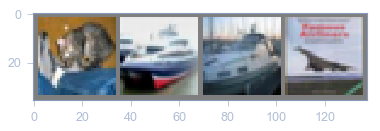

GroundTruth:    cat  ship  ship plane
Predicted  :    cat   car plane plane


In [49]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted  : ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [50]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [51]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 72 %
Accuracy of  bird : 29 %
Accuracy of   cat : 36 %
Accuracy of  deer : 59 %
Accuracy of   dog : 59 %
Accuracy of  frog : 66 %
Accuracy of horse : 60 %
Accuracy of  ship : 61 %
Accuracy of truck : 61 %


In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


In [54]:
net.to(device)
inputs, labels = inputs.to(device), labels.to(device)